## Lab 5 - Jądrowy estymator gęstości (skrót ang. KDE)

Estymator gęstości to algorytm, który pobiera $D$-wymiarowy zbiór danych i generuje oszacowanie rozkładu prawdopodobieństwa $ D $, z którego te dane są pobierane.

Rozpoczynamy od standardowego importu:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

Jak już wspomniano, estymator gęstości to algorytm, który stara się modelować rozkład prawdopodobieństwa posiadanego zbioru danych.
W przypadku danych jednowymiarowych prostym estymatorem gęstości jest **histogram**.
Histogram dzieli dane na dyskretne pojemniki (ang. bin), zlicza punkty, które przypadają na każdy pojemnik, a następnie wizualizuje wyniki w intuicyjny sposób.

Dla przykładu utwórzmy dane, które składają się z dwóch rozkładów normalnych:

In [10]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

Standardowy histogram oparty na zliczeniach można utworzyć za pomocą funkcji ``plt.hist()``.
Określając parametr normalizacji ``density`` otrzymujemy znormalizowany histogram, w którym wysokość przedziałów nie odzwierciedla liczebności, ale zamiast tego odzwierciedla gęstość prawdopodobieństwa:

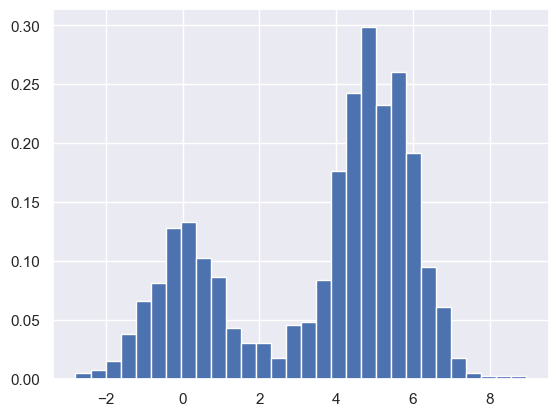

In [11]:
hist = plt.hist(x, bins=30, density=True)

Zauważ, że dla równego podziału na grupy, normalizacja po prostu zmienia skalę na osi y, pozostawiając względne wysokości zasadniczo takie same, jak w histogramie zbudowanym ze zliczeń.
Ta normalizacja jest tak dobrana, aby całkowity obszar pod histogramem był równy 1, co możemy potwierdzić patrząc na wynik funkcji histogramu:

In [12]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

np.float64(1.0)

Jednym z problemów związanych z używaniem histogramu jako estymatora gęstości jest to, że wybór rozmiaru pojemnika i lokalizacji może prowadzić do reprezentacji, które mają jakościowo różne cechy.
Na przykład, jeśli spojrzymy na wersję tych danych, która ma tylko 20 punktów, wybór sposobu narysowania pojemników może prowadzić do zupełnie innej interpretacji danych!
Rozważmy ten przykład:

In [13]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

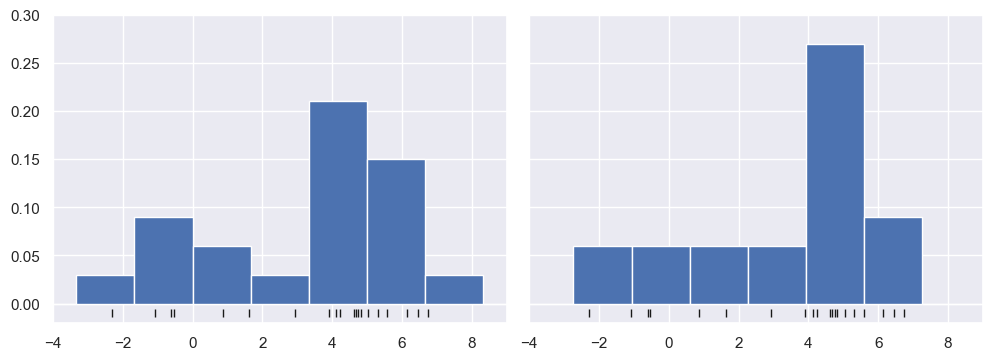

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

Histogram po lewej pokazuje, że jest to rozkład bimodalny.
Po prawej stronie widzimy rozkład unimodalny z długim ogonem.
Nie widząc poprzedniego kodu, prawdopodobnie nie udałoby się nam odgadnąć, że te dwa histogramy zostały zbudowane z tych samych danych: mając to na uwadze, jak możesz ufać intuicji jaką dają histogramy?
Jak możemy to poprawić?

O histogramie możemy myśleć  jako o stosie bloków, w którym układamy jeden blok w każdym koszu na szczycie każdego punktu w zestawie danych.
Spójrzmy na to bezpośrednio:

(-0.2, 8.0)

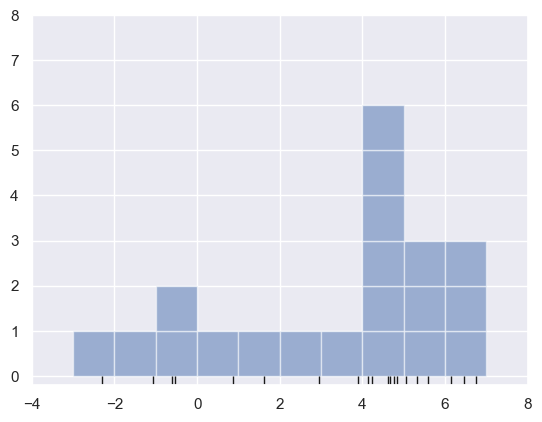

In [15]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

Problem z naszymi dwoma wiązaniami wynika z faktu, że wysokość stosu bloków często nie odzwierciedla rzeczywistej gęstości pobliskich punktów, ale zbieżności tego, jak pojemniki są wyrównane z punktami danych.
To niedopasowanie punktów i ich bloków jest potencjalną przyczyną słabych wyników histogramu, które można zobaczyć tutaj.
Ale co by było, gdybyśmy zamiast układać bloki wyrównanych *pojemników*, mielibyśmy ułożyć bloki wyrównane z *punktami, które reprezentują*?
Jeśli to zrobimy, bloki nie zostaną wyrównane, ale możemy dodać ich wkład w każdym miejscu wzdłuż osi x, aby znaleźć wynik.
Spróbujmy tego:

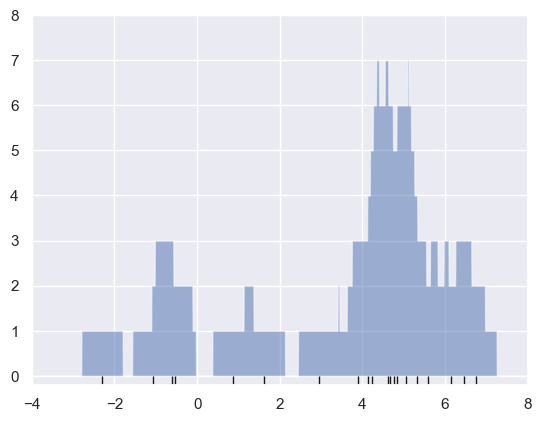

In [16]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

Wynik wygląda trochę niechlujnie, ale jest znacznie bardziej solidnym odzwierciedleniem rzeczywistej charakterystyki danych niż standardowy histogram.

Mimo to szorstkie krawędzie nie są estetyczne ani nie odzwierciedlają żadnych prawdziwych właściwości danych.
Aby je wygładzić, możemy zdecydować się na zastąpienie bloków w każdym miejscu gładką funkcją, taką jak Gaussian.

Użyjmy standardowej krzywej normalnej w każdym punkcie zamiast bloku:

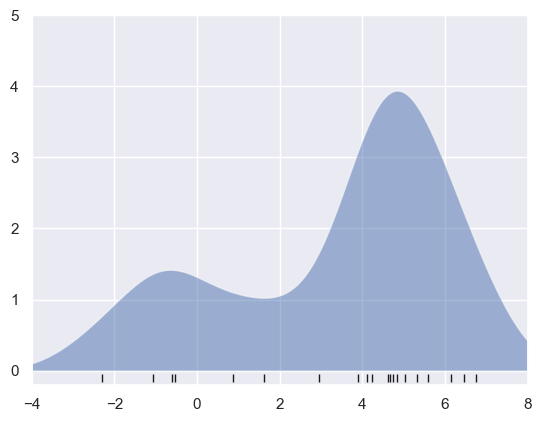

In [17]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Ten wygładzony wykres, z rozkładem Gaussa wniesionym w lokalizacji każdego punktu wejściowego, daje znacznie dokładniejsze wyobrażenie o kształcie rozkładu danych i ma znacznie mniejszą wariancję (tj. Zmienia się znacznie mniej w odpowiedzi na różnice w pobieraniu próbek).

Te dwa ostatnie wykresy są przykładami szacowania gęstości jądra w jednym wymiarze: pierwszy wykorzystuje tak zwane jądro „tophat”, a drugi wykorzystuje jądro Gaussa.

Przyjrzymy się teraz bardziej szczegółowo jądrowemu estymatorowi gęstości.

## Jądrowa Estymacja Gęstości w praktyce (ang. Kernel Density Estimation (KDE))

Parametrami szacowania gęstości jest jądro *ang. kernel*, które określa kształt rozkładu umieszczonego w każdym punkcie oraz *szerokość pasma jądra*, która kontroluje rozmiar jądra w każdym punkcie.

W praktyce istnieje wiele jąder, których możesz użyć do oszacowania gęstości jądra: w szczególności implementacja Scikit-Learn KDE obsługuje jedno z sześciu jąder, o których można przeczytać w [Density Estimation documentation](http://scikit-learn.org/stable/modules/density.html).

Ponieważ KDE może być dość złożone obliczeniowo, estymator Scikit-Learn używa algorytmu opartego na drzewie i może poświęcić czas na dokładność używając parametrów ``atol``  (tolerancja absolutna) i ``rtol`` (tolerancja względna).
Przepustowość jądra, która jest parametrem swobodnym, można określić za pomocą standardowych narzędzi krzyżowego uwiarygodnienia (cross validation) z Scikit-Learn.


Najpierw pokażmy prosty przykład powtórzenia powyższego wykresu za pomocą estymatora Scikit-Learn ``KernelDensity``:

(-0.02, 0.5)

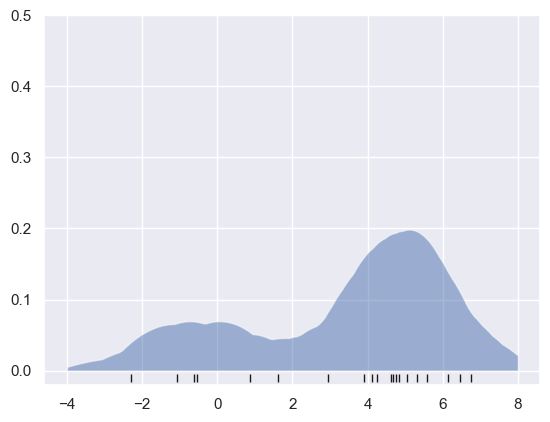

In [18]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=2, kernel='epanechnikov')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.5)

(-0.02, 0.5)

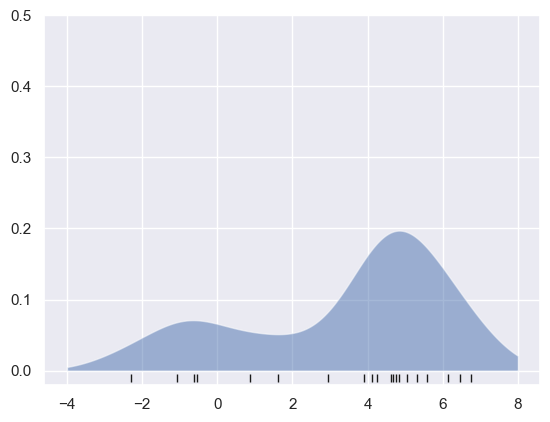

In [11]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.5)

Wynik tutaj jest znormalizowany w taki sposób, że pole powierzchni pod krzywą jest równe 1.

### Wybór pasma przy pomocy walidacji krzyżowej (ang. cross-validation)

Wybór szerokości pasma w KDE jest niezwykle ważny dla znalezienia odpowiedniego oszacowania gęstości i jest pokrętłem, które kontroluje kompromis między odchyleniem a wariancją w oszacowaniu gęstości: zbyt wąskie pasmo prowadzi do oszacowania dużej wariancji (over-fitting), gdzie obecność lub brak pojedynczego punktu robi dużą różnicę. Zbyt szerokie pasmo prowadzi do oszacowania wysokiego obciążenia (under-fitting), w którym struktura danych jest wymywana przez szerokie jądro.

Statystyka metod szybkiego szacowania najlepszej przepustowości ma długą historię w oparciu o dość rygorystyczne założenia dotyczące danych: jeśli na przykład przejrzysz implementacje KDE w pakietach SciPy i StatsModels, zobaczysz implementacje oparte na niektórych z tych zasady.

W kontekstach uczenia maszynowego widzieliśmy, że takie strojenie hiperparametrów często odbywa się empirycznie za pomocą metody weryfikacji krzyżowej.
Mając to na uwadze, estymator ``KernelDensity`` w Scikit-Learn jest zaprojektowany w taki sposób, że może być używany bezpośrednio w standardowych ``GridSearchCV``.

Ponieważ patrzymy na tak mały zbiór danych, zastosujemy walidację krzyżową z pominięciem jednego wyjścia, które minimalizuje redukcję rozmiaru zestawu uczącego dla każdej próby walidacji krzyżowej:

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

Teraz możemy znaleźć wybór przepustowości, który maksymalizuje wynik (który w tym przypadku jest domyślną logarytmiczną funkcją wiarygodności):

In [42]:
grid.best_params_['bandwidth']

{'bandwidth': np.float64(6.135907273413174)}

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='epanechnikov'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);
grid.best_params_

/Users/daniel/repos/ZMUM/zmum/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
 -2.63542892 -2.50182629 -2.46232223 -2.43697351 -2.41363001 -2.3941289
 -2.38514175 -2.37883179 -2.36414488 -2.34969832 -2.33980661 -2.33297644
 -2.32776804 -2.32218493 -2.3169056  -

{'bandwidth': np.float64(2.3644894126454084)}

Optymalne przepustowości są bardzo zbliżone do tych, których użyliśmy na wcześniejszych przykładowych wykresach, gdzie przepustowość dla jądra Gaussa ustawiliśmy 1.0 ( domyślna szerokość ``scipy.stats.norm``), a dla Epanechnikowa 2.

## Przykład: KDE na sferze

Być może najbardziej powszechnym zastosowaniem KDE jest graficzne przedstawianie dystrybucji punktów.
Na przykład w bibliotece wizualizacji Seaborn, KDE jest wbudowane i automatycznie używane do wizualizacji punktów w jednym i dwóch wymiarach.

Tutaj przyjrzymy się nieco bardziej wyrafinowanemu wykorzystaniu KDE do wizualizacji dystrybucji.
Wykorzystamy niektóre dane geograficzne, które można załadować za pomocą Scikit-Learn: geograficzne rozmieszczenie zarejestrowanych obserwacji dwóch południowoamerykańskich ssaków, *Bradypus variegatus* (leniwiec brunatny) i *Microryzomys minutus* (leśny mały szczur ryżowy).

Dzięki Scikit-Learn możemy pobrać te dane w następujący sposób:

In [15]:
import numpy as np
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

Po załadowaniu tych danych możemy użyć zestawu narzędzi do wykreślenia obserwowanych lokalizacji tych dwóch gatunków na mapie Ameryki Południowej.

In [16]:
import os

os_file_dir = os.__file__
os_dir = os_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(os_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

NameError: name 'Basemap' is not defined

Niestety nie daje to dobrego wyobrażenia o zagęszczeniu gatunku, ponieważ punkty w zasięgu gatunków mogą się na siebie nakładać. Mamy tu ponad 1600 punktów.

Użyjmy oszacowania gęstości przy pomocy estymatora jądrowego, aby pokazać ten rozkład w bardziej interpretowalny sposób: jako płynne wskazanie gęstości na mapie. Ponieważ układ współrzędnych leży tutaj na powierzchni kulistej, a nie na płaskiej płaszczyźnie, użyjemy metryki odległości ``haversine``, która będzie poprawnie przedstawiać odległości na zakrzywionej powierzchni.

Jest tu trochę standardowego kodu (jedna z wad zestawu narzędzi mapy bazowej), ale znaczenie każdego bloku kodu powinno być jasne:

In [ ]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

W porównaniu z prostym wykresem punktowym, którego używaliśmy na początku, ta wizualizacja przedstawia znacznie wyraźniejszy obraz geograficznego rozmieszczenia obserwacji tych dwóch gatunków.

## Przykład: Naiwny Bayes

Ten przykład przedstawia klasyfikację generatywną Bayesa w KDE i demonstruje, jak używać architektury Scikit-Learn do tworzenia niestandardowego estymatora.

Za pomocą algorytmu szacowania gęstości, takiego jak KDE, możemy usunąć element „naiwny” i przeprowadzić taką samą klasyfikację z bardziej wyrafinowanym modelem generującym dla każdej klasy.
To wciąż klasyfikacja Bayesa, ale nie jest już naiwna.

Ogólne podejście do klasyfikacji generatywnej jest następujące:

1. Podziel dane treningowe według etykiet.

2. Dla każdego zestawu dopasuj KDE, aby uzyskać generatywny model danych.
   Pozwala to na wyliczenie funkcji wiarygodności $P(x~|~y)$ dla dowolnej obserwacji  $x$ i etykiety $y$.
   
3. Z liczby przykładów każdej klasy w zbiorze uczącym oblicz *class prior*, $P(y)$.

4. Dla nieznanego punktu $x$, prawdopodobieństwo posterior dla każdej klasy wynosi $P(y~|~x) \propto P(x~|~y)P(y)$.
   Maksymalna wartość przypisana zostaje do danego punktu.

Algorytm jest prosty i intuicyjny do zrozumienia; trudniejszym elementem jest umieszczenie go w ramach Scikit-Learn w celu wykorzystania architektury wyszukiwania w siatce i weryfikacji krzyżowej.

To jest kod, który implementuje algorytm w ramach Scikit-Learn; przejdziemy przez to zgodnie z blokiem kodu:

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Anatomia estymatora niestandardowego

Przejdźmy przez ten kod i omówmy najważniejsze funkcje:

```python
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
```


Dalej jest metoda inicjalizacji klasy:

```python
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

To jest rzeczywisty kod, który jest wykonywany, gdy obiekt jest tworzony za pomocą``KDEClassifier()``.
W Scikit-Learn ważne jest, aby *initialization contains no operations* other than assigning the passed values by name to ``self``.
Wynika to z logiki zawartej w `` BaseEstimator `` wymaganej do klonowania i modyfikowania estymatorów do walidacji krzyżowej, przeszukiwania siatki i innych funkcji.
Podobnie, wszystkie argumenty do `` __init__ `` powinny być jawne: tj. Należy unikać `` * args `` lub `` ** kwargs ``, ponieważ nie będą one poprawnie obsługiwane w ramach procedur weryfikacji krzyżowej.


Dalej jest metoda `` fit () `` , w której obsługujemy dane treningowe:
```python 
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

Tutaj znajdziemy unikalne klasy w danych treningowych, trenuj ``KernelDensity`` model dla każdej klasy i obliczyć wcześniejsze klasy na podstawie liczby próbek wejściowych.
Ostatecznie, ``fit()`` powinien zawsze zwracać ``self`` abyśmy mogli łączyć polecenia. Na przykład:
```python
label = model.fit(X, y).predict(X)
```
Zauważ, że każdy trwały wynik dopasowania jest przechowywany z końcowym podkreśleniem  (``self.logpriors_``).
Jest to konwencja używana w Scikit-Learn, dzięki czemu można szybko przeskanować elementy składowe estymatora (za pomocą uzupełniania zakładek w IPython) i zobaczyć dokładnie, którzy członkowie są dopasowani do danych szkoleniowych.

Wreszcie mamy logikę przewidywania etykiet dla nowych danych:
```python
    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```
Ponieważ jest to klasyfikator probabilistyczny, najpierw  implementujemy ``predict_proba()`` która zwraca tablicę prawdopodobieństw klas o wymiarze ``[n_samples, n_classes]``.
``[i, j]`` tej tablicy jest późniejszym prawdopodobieństwem z jakim ``i``-ta próbka jest członkiem klasy ``j``, obliczane przez pomnożenie prawdopodobieństwa przez klasę wcześniejszą i normalizującą.

Ostatecznie metoda  ``predict()`` wykorzystuje te prawdopodobieństwa i po prostu zwraca klasę z największym prawdopodobieństwem.

### Korzystanie z naszego kalkulatora niestandardowego

Wypróbujmy ten niestandardowy estymator w przypadku problemu, który widzieliśmy wcześniej: klasyfikacji odręcznych cyfr.
Tutaj załadujemy cyfry i obliczymy wynik weryfikacji krzyżowej dla zakresu kandydujących przepustowości przy użyciu metody ``GridSearchCV``

In [19]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

grid.best_params_



{'bandwidth': np.float64(6.135907273413174)}

Następnie możemy wykreślić wynik weryfikacji krzyżowej jako funkcję tłumienia:

In [20]:
grid.cv_results_['mean_test_score']

array([0.44853141, 0.41846332, 0.52088982, 0.38062519, 0.43183999,
       0.40958217, 0.43182916, 0.47247292, 0.42793562, 0.43462396,
       0.46186011, 0.45132312, 0.50809192, 0.50530486, 0.59547199,
       0.62383627, 0.68450634, 0.67948004, 0.74514547, 0.79690963,
       0.82196224, 0.85700557, 0.88594398, 0.91099041, 0.92545342,
       0.93991334, 0.95048747, 0.95716651, 0.96049985, 0.96328072,
       0.96495048, 0.96606159, 0.96606314, 0.96661869, 0.96661869,
       0.96662024, 0.96606314, 0.96661869, 0.96661869, 0.96772981,
       0.96717425, 0.96661869, 0.9671758 , 0.96606314, 0.96606469,
       0.96495357, 0.96439802, 0.96217425, 0.95994893, 0.95605076,
       0.95605076, 0.95604921, 0.9543779 , 0.95215258, 0.95047973,
       0.94769576, 0.94658155, 0.94156763, 0.94045497, 0.93711699,
       0.93489322, 0.92988394, 0.92376354, 0.91930826, 0.91430362,
       0.90762303, 0.90261529, 0.89983287, 0.897606  , 0.89426493,
       0.89092386, 0.89036831, 0.88703188, 0.88258124, 0.87757

accuracy = 0.9677298050139276


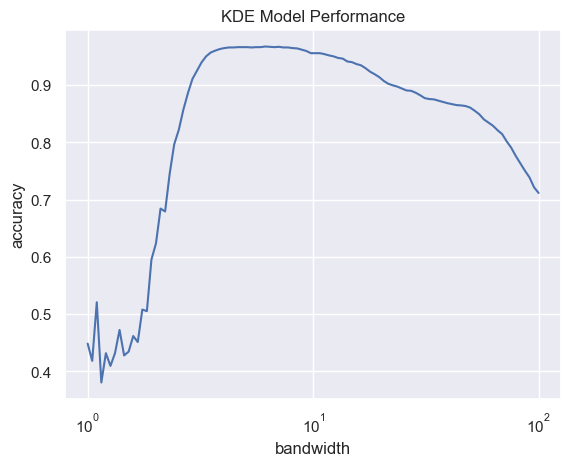

In [21]:
plt.semilogx(grid.param_grid['bandwidth'], grid.cv_results_['mean_test_score'])
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')

print('accuracy =', grid.best_score_)

Widzimy, że ten niezbyt naiwny klasyfikator bayesowski osiąga dokładność walidacji krzyżowej nieco ponad 96%; jest to w porównaniu z około 80% dla naiwnej klasyfikacji bayesowskiej:

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

np.float64(0.8069281956050759)

Jedną z zalet takiego generatywnego klasyfikatora jest interpretowalność wyników: dla każdej nieznanej próbki otrzymujemy nie tylko klasyfikację probabilistyczną, ale także *pełny model* rozkładu punktów, z którymi ją porównujemy!
W razie potrzeby oferuje to intuicyjne okno na przyczyny określonej klasyfikacji, które algorytmy takie jak maszyny SVM i losowe lasy zwykle zaciemniają.

Jeśli chcesz pójść dalej, istnieje kilka ulepszeń, które można wprowadzić w naszym modelu klasyfikatora KDE:

- moglibyśmy pozwolić, aby przepustowość w każdej klasie zmieniała się niezależnie
- moglibyśmy zoptymalizować te przepustowości nie na podstawie ich wyniku predykcji, ale na podstawie prawdopodobieństwa danych uczących w ramach modelu generatywnego w każdej klasie (tj. użyć wyników z samego `` KernelDensity `` zamiast globalnej dokładności prognoz)

Na koniec, jeśli chcesz trochę poćwiczyć budowanie własnego estymatora, możesz zająć się budowaniem podobnego klasyfikatora bayesowskiego przy użyciu  Gaussian Mixture Models <https://scikit-learn.org/stable/modules/mixture.html> zamiast KDE.


In [47]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import LeaveOneOut

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE with optimized class-specific bandwidth"""
    def __init__(self, bandwidths='optimize', kernel='gaussian', bandwidth_grid=None):
        self.bandwidths = bandwidths
        self.kernel = kernel
        self.bandwidth_grid = bandwidth_grid if bandwidth_grid is not None else np.logspace(-2, 1, 20)
        
    def fit(self, X, y):
        # Identify unique classes and sort them
        self.classes_ = np.sort(np.unique(y))
        
        # Prepare for bandwidth optimization for each class
        self.training_sets_ = [X[y == yi] for yi in self.classes_]
        self.models_ = []
        self.optimized_bandwidths_ = []
        
        # For each class, either optimize the bandwidth or use given values
        for Xi in self.training_sets_:
            if self.bandwidths == 'optimize':
                bandwidths = self.bandwidth_grid
                grid = GridSearchCV(KernelDensity(kernel=self.kernel),
                    {'bandwidth': bandwidths})
                grid.fit(Xi);
                best_bandwidth = grid.best_params_['bandwidth']
            else:
                best_bandwidth = self.bandwidths

            # Store the optimized bandwidth and KDE model
            self.optimized_bandwidths_.append(best_bandwidth)
            kde_model = KernelDensity(bandwidth=best_bandwidth, kernel=self.kernel).fit(Xi)
            self.models_.append(kde_model)

        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in self.training_sets_]
        
        return self

    def predict_proba(self, X):
        # Compute log-probabilities for each class
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        
        # Convert log-probabilities to normal probabilities and normalize
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        # Predict the class with the highest probability for each sample
        return self.classes_[np.argmax(self.predict_proba(X), 1)]


# Load digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train KDEClassifier
kde_clf = KDEClassifier()
kde_clf.fit(X_train, y_train)

# Predict on the test set and evaluate accuracy
y_pred = kde_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.6444444444444445